In [1]:
import wandb
api = wandb.Api()

# Just load seaborn & set theme and the chart looks better:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

# set matplotlib dpi to 200 to make the images bigger
plt.rcParams['figure.dpi'] = 200
wandb_cache = {}

In [33]:
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10", "loss": "Loss", "perplexity": "Perplexity"}

def is_loss_metric(metric_name):
    if metric_name == "perplexity":
        return True
    if metric_name[-4:] == "loss":
        return True
    return False

def get_data(h, dataset, key):
    if key == "perplexity":
        arr = np.array([ float(x) for x in h[f"loss_data/{dataset}/loss"]])
        if np.isnan(arr[0]):
            return np.ones_like(arr)
        return np.exp(arr)
    if is_loss_metric(key):
        arr = np.array([ float(x) for x in h[f"loss_data/{dataset}/{key}"]])
        if np.isnan(arr[0]):
            return np.ones_like(arr)
        return arr
    return h[f"accuracy/{dataset}/{key}"]

def get_data_normed(h, dataset, key):
    arr = get_data(h, dataset, key)
    return arr/arr[0]

def get(h, dataset, key, normed=False):
    if normed:
        return get_data_normed(h, dataset, key)
    return get_data(h, dataset, key)

class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]

        if self.run_name in wandb_cache:
            self.run = api.run(self.run_name)
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run

        self.history = self.run.history()
        self.h = self.history
        c = self.run.config

        self.model_name = c["model_size"].split("/")[-1].lower()

        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac

        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = self.cripple
        self.focus_label   = self.focus

        # Get "unique" names
        self.name_set = self.focus_label + " " + self.cripple_label
        self.name_set_model = self.name_set + " " + self.model_name

    def get_metric(self, metric):
        if is_loss_metric(metric):
            return self.get_loss_metric(metric)
        return self.get_d_metric(metric)

    def get_d_metric(self, metric):
        self.scale = 100
        focus_perf     = get_data(self.h, self.focus,   metric) * self.scale
        cripple_perf   = get_data(self.h, self.cripple, metric) * self.scale
        return focus_perf, cripple_perf


def plot_frac_pruned(run_obj, metric, **kwargs):
    r = run_obj
    focus_perf   = get_data(r.h, r.focus, metric)
    metric_name = metric_map[metric]

    # Begin plotting
    plt.plot(r.frac*100, focus_perf, **kwargs)

    # Add details
    plt.xlim(-0.01, 100)
    plt.ylim(-0.01, None)
    plt.xlabel("Percentage of Model Pruned (%)")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} ({r.model_name})")
    plt.legend()

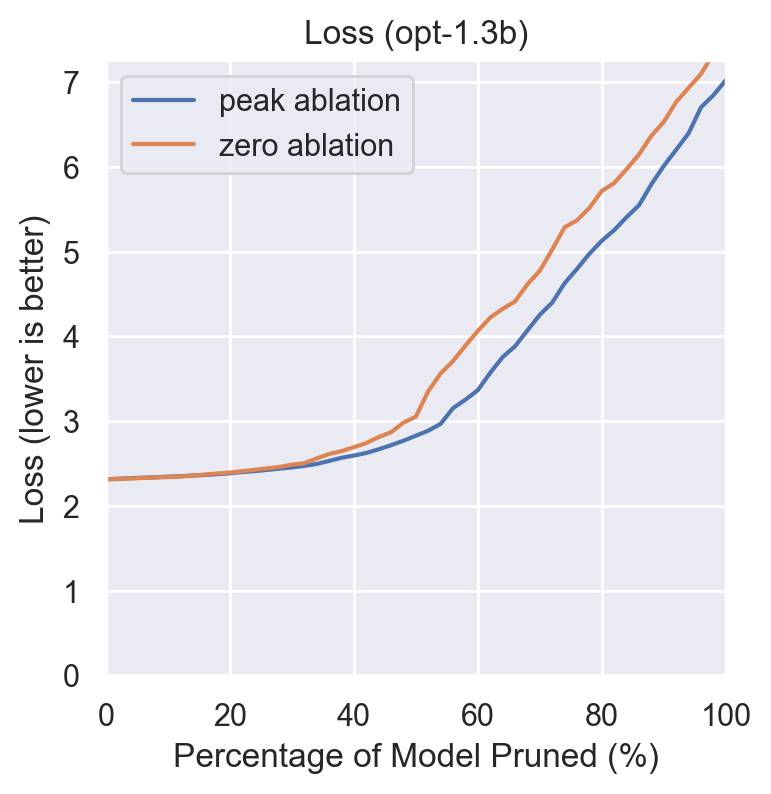

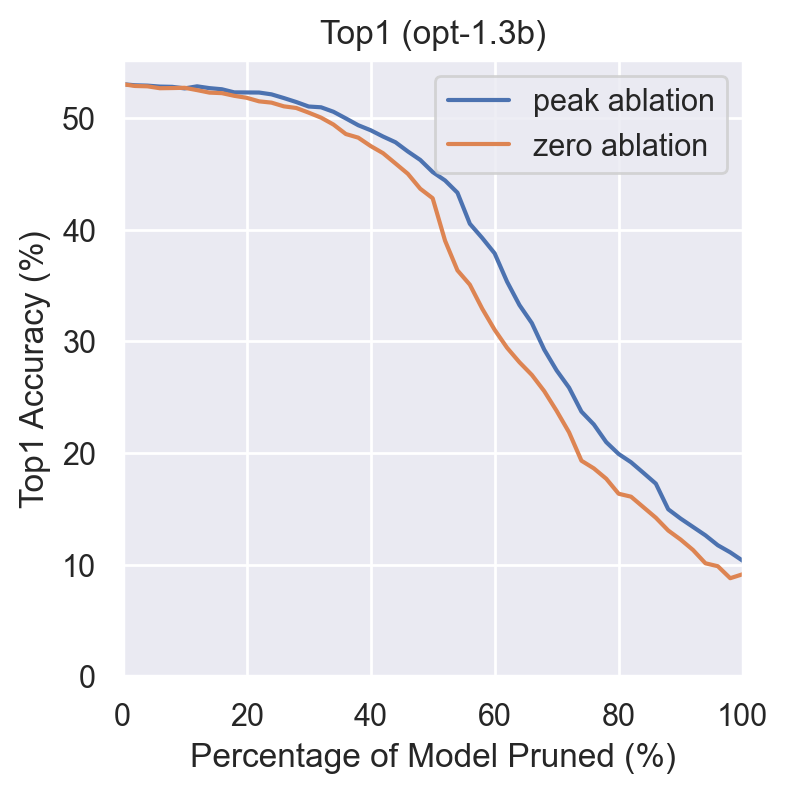

In [36]:
wandb_runs = [
    ("https://wandb.ai/seperability/skylar-tests/runs/huo09rwx", "peak ablation"),
    ("https://wandb.ai/seperability/skylar-tests/runs/77kyl2wi", "zero ablation")
]

plt.figure(figsize=(4,4))
for x in wandb_runs:
    plot_frac_pruned(WandbRunData(x[0]), "loss", label=x[1])
plt.ylim(None, None)
plt.ylabel("Loss (lower is better)")
plt.show()

plt.figure(figsize=(4,4))
for x in wandb_runs:
    plot_frac_pruned(WandbRunData(x[0]), "base", label=x[1])
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.show()